## Power Spectral Density

### Loading Dataset

In [1]:
!wget https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip

--2024-07-04 11:43:38--  https://physionet.org/static/published-projects/eegmat/eeg-during-mental-arithmetic-tasks-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183634285 (175M) [application/zip]
Saving to: 'eeg-during-mental-arithmetic-tasks-1.0.0.zip'

eeg-during-mental-a 100%[===================>] 175.13M   521KB/s    in 6m 8s   

2024-07-04 11:49:46 (488 KB/s) - 'eeg-during-mental-arithmetic-tasks-1.0.0.zip' saved [183634285/183634285]



In [2]:
!unzip eeg-during-mental-arithmetic-tasks-1.0.0.zip

Archive:  eeg-during-mental-arithmetic-tasks-1.0.0.zip
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject24_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/SHA256SUMS.txt  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_2.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_1.edf  
 extracting: eeg-during-mental-arithmetic-tasks-1.0.0/Subject17_1.edf  
 extractin

### Importing Libraries

In [3]:
!pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.7 MB/s eta 0:00:0000:0100:01


In [4]:
import os
import pyedflib
import pandas as pd
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns

### Data Processing

In [ ]:
#Loading data
signals = []
file_name = []

directory_path = "eeg-during-mental-arithmetic-tasks-1.0.0"
for file in os.listdir(directory_path):
    if file.endswith(".edf"):
        file_name.append(file)
        file_path = os.path.join(directory_path, file)
        f = pyedflib.EdfReader(file_path)
        num_signals = f.signals_in_file
        signal = []
        for i in range(num_signals):
            signal.append(f.readSignal(i))
        signals.append(signal)
        f.close()

In [6]:
#Dataframe preparation
df = pd.DataFrame({
    'Signal': signals,
    'Name': file_name,
})
df.sort_values(by='Name', ascending=True, inplace=True)
df = df.reset_index().drop(columns=['index'])
df['State'] = df['Name'].str[10:11].astype(int)
df['Person'] = df['Name'].str[7:9].astype(int)
df = df.drop(columns = ['Name'])

In [7]:
df.head()

,Signal,State,Person
0,"[[-3.647937628137637, -4.2364816766613265, -4....",1,0
1,"[[4.476049125658048, 1.2080211680781288, -2.54...",2,0
2,"[[-6.347912214236662, -5.884709218585484, -5.1...",1,1
3,"[[13.990337165484092, 12.876662806134126, 11.8...",2,1
4,"[[-1.4898168015564115, -3.518470470435636, -5....",1,2


### Psd Calculation

In [8]:
def calculate_band_powers(eeg_data):
    fs = 500 #Sampling rate
    bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 100)}
    
    band_powers = {band: [] for band in bands}
    
    for channel in eeg_data: #Iterating through each channel
        f, psd = welch(channel, fs, nperseg=1024) #Returns the power and corresponding frequncy for each channel
        for band, (low, high) in bands.items():
            band_power = np.trapz(psd[(f >= low) & (f <= high)], f[(f >= low) & (f <= high)]) #Adding the power in each band
            band_powers[band].append(band_power) 
            total_power = {band: np.sum(powers) for band, powers in band_powers.items()}

    return total_power #Returning dictionary containing power in each band

In [9]:
#Initializing dataframe for rest and task
df_rest = pd.DataFrame(columns=['Delta','Theta','Alpha','Beta','Gamma'])
df_task = pd.DataFrame(columns=['Delta','Theta','Alpha','Beta','Gamma'])

In [10]:
for index, row in df.iterrows():
    if row['State'] == 1:
        x = calculate_band_powers(row['Signal'])
        x = pd.DataFrame([x])
        df_rest = pd.concat([df_rest, x], ignore_index=True)
    
    elif row['State'] == 2:
        x = calculate_band_powers(row['Signal'])
        x = pd.DataFrame([x])
        df_task = pd.concat([df_task, x], ignore_index=True)

/tmp/ipykernel_34/561902003.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_rest = pd.concat([df_rest, x], ignore_index=True)
/tmp/ipykernel_34/561902003.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_task = pd.concat([df_task, x], ignore_index=True)


**So now we have 2 dataframes :** <br> 
```df_rest``` - Contains the total power across each channel for a band, for a person at rest. <br>
```df_task``` - Contains the total power across each channel for a band, for a person at task.

In [11]:
df_rest.head()

,Delta,Theta,Alpha,Beta,Gamma
0,450.191805,244.108001,905.359753,492.597515,28.485613
1,348.563156,207.759343,287.572089,370.574169,55.392396
2,600.656098,210.918975,543.541052,511.926819,110.689917
3,349.694534,331.827997,1017.884748,255.635971,24.078535
4,1001.094762,503.771688,729.250619,554.973260,43.317515


In [12]:
df_task.head()

,Delta,Theta,Alpha,Beta,Gamma
0,571.896743,234.168000,804.732005,499.094898,39.493581
1,1113.988845,390.479589,267.519252,368.105158,52.684654
2,407.268558,143.862281,380.381411,505.572866,114.856310
3,266.956729,180.787108,304.425754,139.136489,15.372531
4,687.415601,458.596439,400.506125,505.875213,24.036411


### Analysis

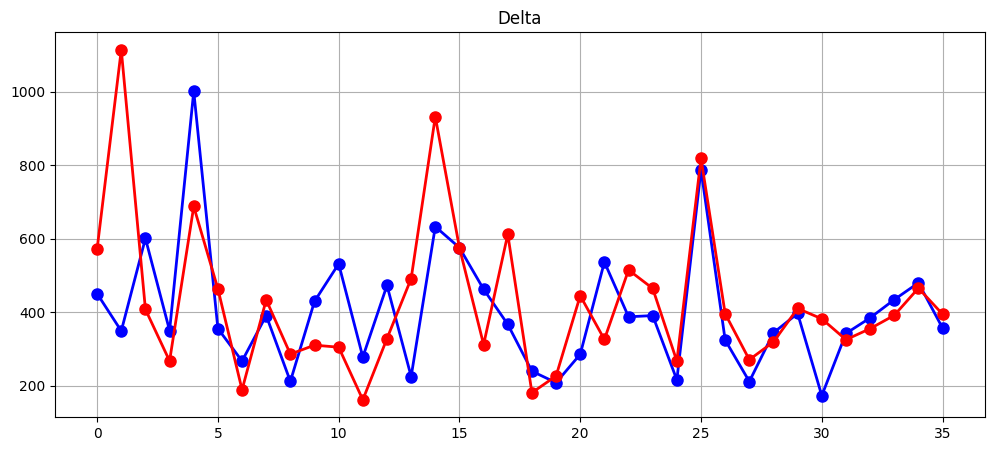

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Delta'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Delta'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Delta')
plt.show()

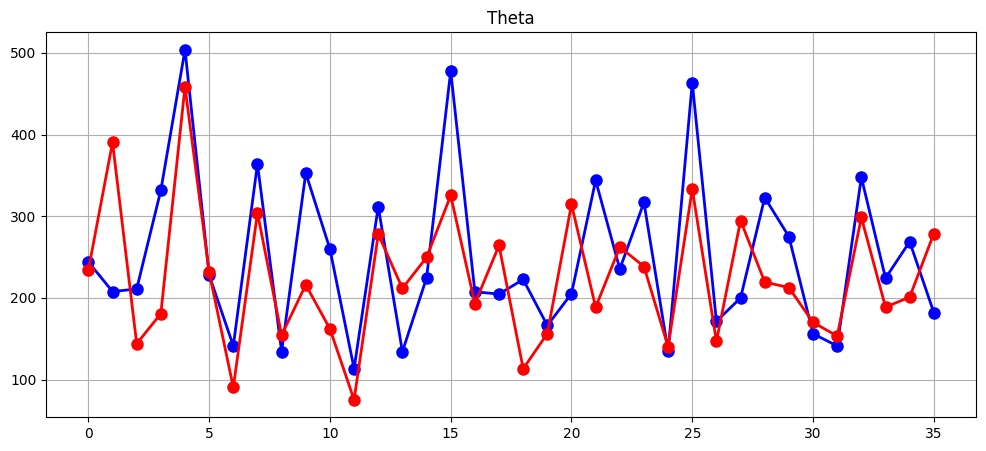

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Theta'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Theta'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Theta')
plt.show()

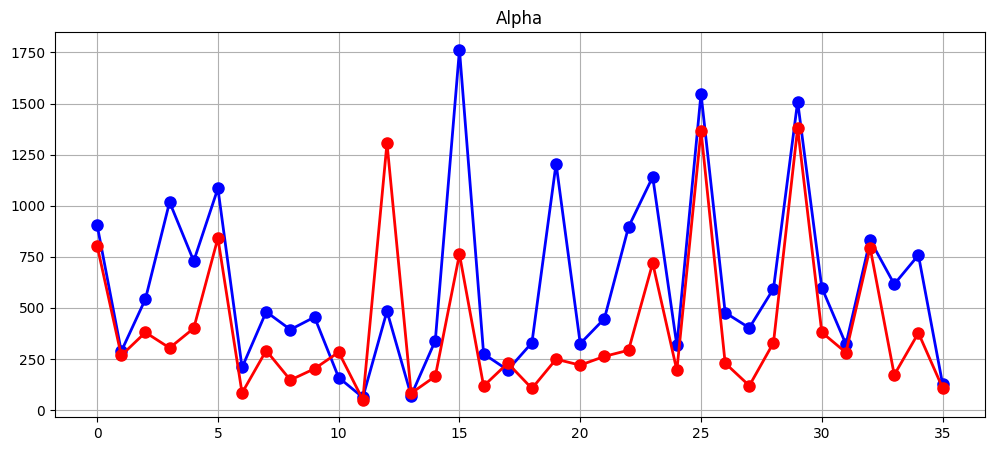

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Alpha'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Alpha'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Alpha')
plt.show()

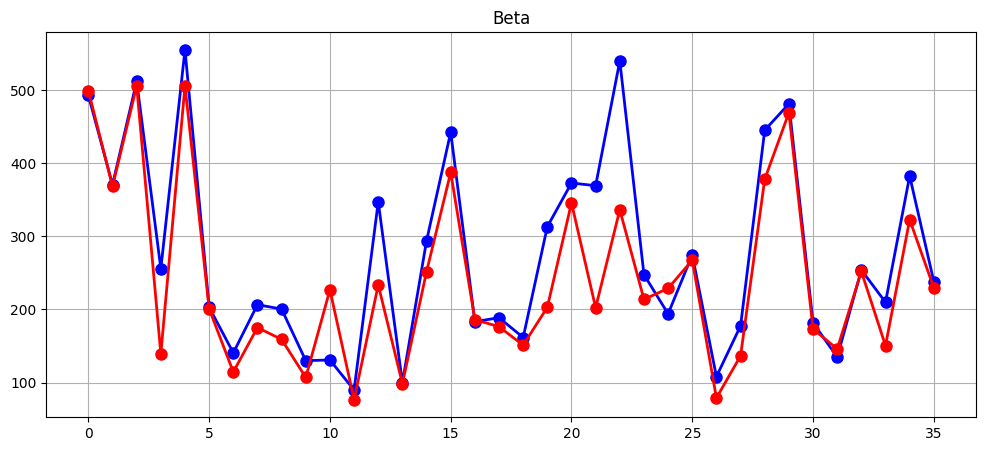

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Beta'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Beta'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Beta')
plt.show()

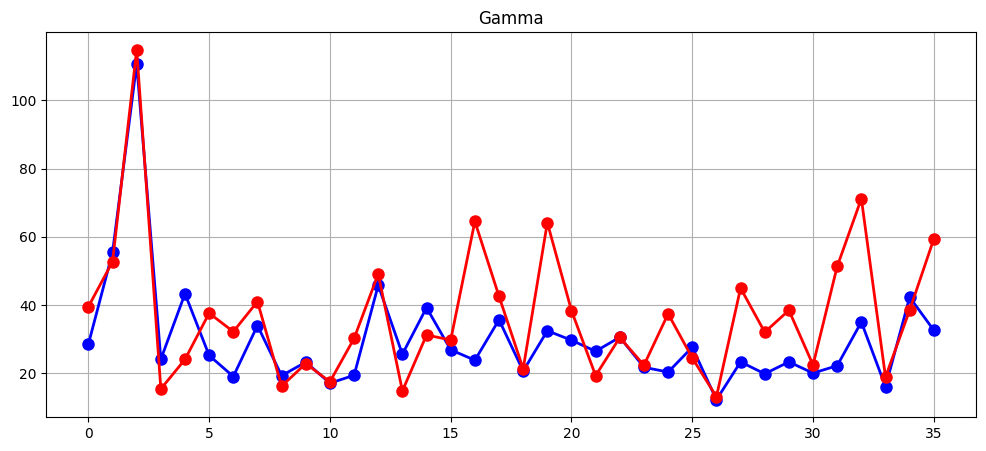

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(df_rest['Gamma'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.plot(df_task['Gamma'],  marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.grid(True)
plt.title('Gamma')
plt.show()

## CONCLUSION
Delta - Largely remains same in both irrespective of rest or task. <br>
Theta - Largely follows the same trajectory with slightly more power during task.<br>
Alpha - It can be clearly seen that more power is emitted during arithmetic task.<br>
Beta - A trend similar to alpha is observed. <br>
Gamma - Remains largely the same. <br>

